In [1]:
import os

In [2]:
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.objects.log.adapters.pandas import csv_import_adapter
from pm4py.algo.discovery.dfg.adapters.pandas import df_statistics
from pm4py import util as pmutil

from pandas import read_csv
file = read_csv(os.path.join("files","input_data","sepsis.csv"))

log = csv_import_adapter.convert_timestamp_columns_in_df(file, timest_columns=[
    'timestamp'
])
dfg_frequency, dfg_performance = df_statistics.get_dfg_graph(log, measure="both",
                                                            activity_key='activity',
                                                            timestamp_key='timestamp',
                                                            case_id_glue='case_id')

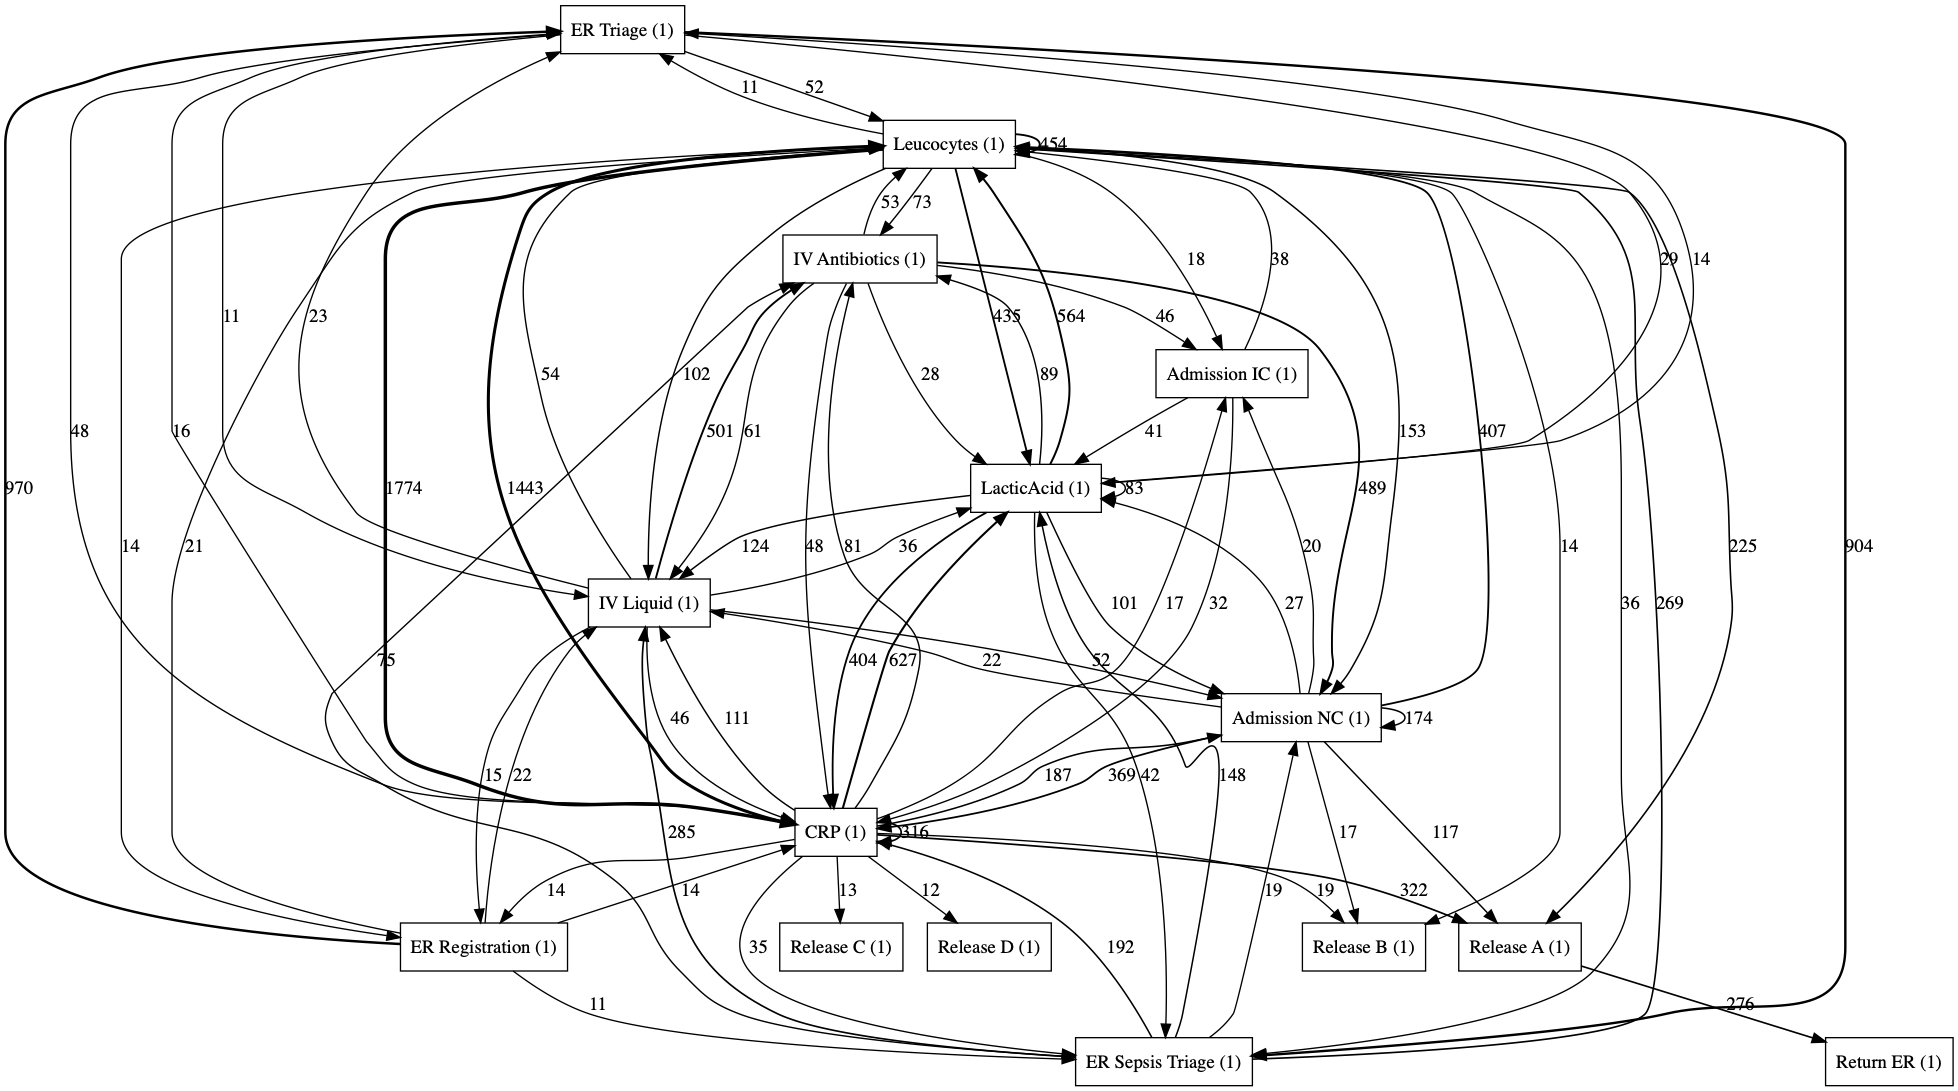

In [3]:
from pm4py.visualization.dfg import factory as dfg_vis_factory

gviz = dfg_vis_factory.apply(dfg_frequency, variant="frequency")
dfg_vis_factory.view(gviz)

In [5]:
from ntnu_process_mining import ProcessMap



process_map = ProcessMap()

def on_filter_change(change={}):
    pm_edges = []
    max_weight = max([freq for edge,freq in dfg_frequency.items()])
    for (src, dst), weight in dfg_frequency.items():
        if max_weight*(process_map.filter/100) <= weight:
            pm_edges.append({"from": src, "to": dst, "value": weight})
    process_map.value=pm_edges

process_map.observe(on_filter_change, names='filter')

on_filter_change()
process_map

ProcessMap(value=[{'from': 'CRP', 'to': 'Leucocytes', 'value': 1443}, {'from': 'ER Registration', 'to': 'ER Tr…